# 7. IMPLEMENTATION

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
fifa = pd.read_csv('D:\\Downloads\\CompleteDataset.csv\\CompleteDataset.csv')

In [3]:
fifa.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,€95.5M,€565K,ST LW
1,L. Messi,30,Argentina,93,93,FC Barcelona,€105M,€565K,RW
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,€123M,€280K,LW
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,€97M,€510K,ST
4,M. Neuer,31,Germany,92,92,FC Bayern Munich,€61M,€230K,GK


In [4]:
fifa = fifa.dropna()

In [5]:
fifa.dtypes

Name                   object
Age                     int64
Nationality            object
Overall                 int64
Potential               int64
Club                   object
Value                  object
Wage                   object
Preferred Positions    object
dtype: object

# DATA TRIMMING FOR VALUES AND WAGES COMPARISON

In [6]:
fifa['Value'] = fifa['Value'].str.replace(',', '')
fifa['Value'] = fifa['Value'].str.replace('€', '')

In [7]:
fifa.Value = (fifa.Value.replace(r'[KM]+$', '', regex=True).astype(float) * \
   ....:           fifa.Value.str.extract(r'[\d\.]+([KM]+)', expand=False)
   ....:             .fillna(1)
   ....:             .replace(['K','M'], [10**3, 10**6]).astype(int))

In [8]:
fifa['Wage'] = fifa['Wage'].str.replace(',', '')
fifa['Wage'] = fifa['Wage'].str.replace('€', '')

In [9]:
fifa.Wage = (fifa.Wage.replace(r'[KM]+$', '', regex=True).astype(float) * \
   ....:           fifa.Wage.str.extract(r'[\d\.]+([KM]+)', expand=False)
   ....:             .fillna(1)
   ....:             .replace(['K','M'], [10**3, 10**6]).astype(int))

In [10]:
fifa.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,95500000.0,565000.0,ST LW
1,L. Messi,30,Argentina,93,93,FC Barcelona,105000000.0,565000.0,RW
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,123000000.0,280000.0,LW
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,97000000.0,510000.0,ST
4,M. Neuer,31,Germany,92,92,FC Bayern Munich,61000000.0,230000.0,GK


In [11]:
fifa.dtypes

Name                    object
Age                      int64
Nationality             object
Overall                  int64
Potential                int64
Club                    object
Value                  float64
Wage                   float64
Preferred Positions     object
dtype: object

In [12]:
# Networkx graph with two sets of bipartite nodes
B = nx.Graph()
B.add_nodes_from(fifa['Name'], bipartite=0)
B.add_nodes_from(fifa['Club'], bipartite=1)

# Extract data from the main dataframe and add as weighted edges
weighted_edges = fifa[['Name', 'Club','Overall']].apply(tuple,axis=1).tolist()
B.add_weighted_edges_from(weighted_edges)

In [13]:
# Capture Biggest connected graph and test
B = max((B.subgraph(c) for c in nx.connected_components(B)), key=len)
nx.is_connected(B)

True

In [ ]:
player_nodes = set(n for n,d in B.nodes(data=True) if d['bipartite']==0)
club_nodes = set(B) - player_nodes

# Island Method

In [15]:
def trim_edges(g, weight=1):
    g2 = nx.Graph()
    
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
            
    return g2

In [16]:
def island_method(g, iterations=6):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [17]:
cc = sorted((B.subgraph(c) for c in nx.connected_components(B)), key = len, reverse=True)[0]
islands = island_method(cc)

# Graph Visualization

In [18]:
node_colors = []
for n in islands[4][1].nodes(data=True):
    if n[0] in player_nodes:
        node_colors.append('#3366ff')
    else:
        node_colors.append('#40bf80')

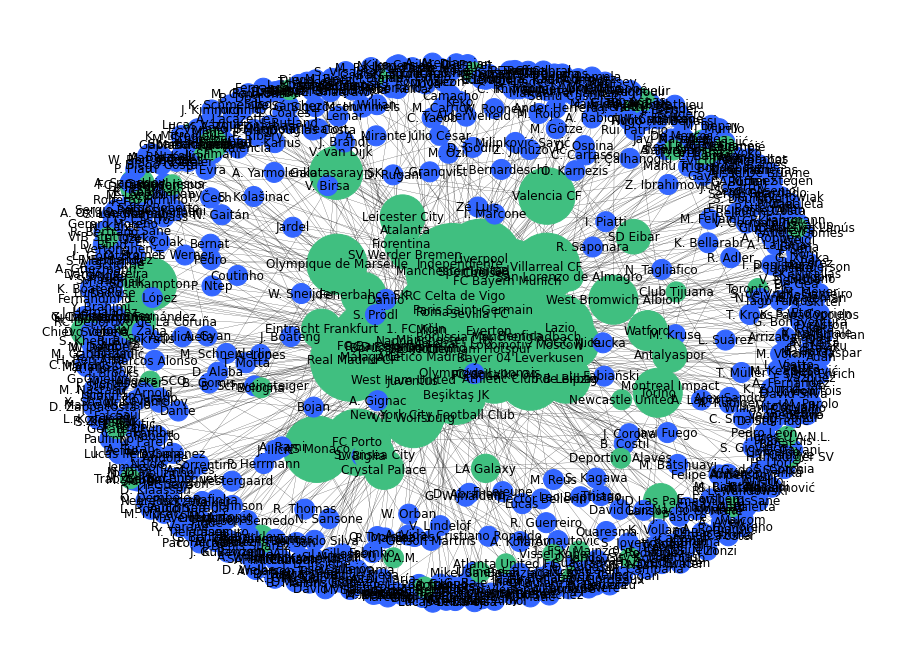

In [19]:
plt.rcParams['figure.figsize'] = [16, 12]

pos = nx.spring_layout(islands[4][1], k=2) # k=2 values helps spread the nodes

# Degree calculations to denote the size of nodes
degree = dict(nx.degree(islands[4][1]))


degree_graph = nx.draw_networkx(islands[4][1], 
                                pos=pos,
                                node_color=node_colors,
                                node_size=np.multiply(list(degree.values()), 400), # multiply degree by 400 for better resolution
                                with_labels=True, 
                                width=0.2)

# Remove axis
limits=plt.axis('off')

In [20]:
node_colors = []

for n in islands[5][1].nodes(data=True):
    if n[0] in player_nodes:
        node_colors.append('#3366ff')
    else:
        node_colors.append('#40bf80')

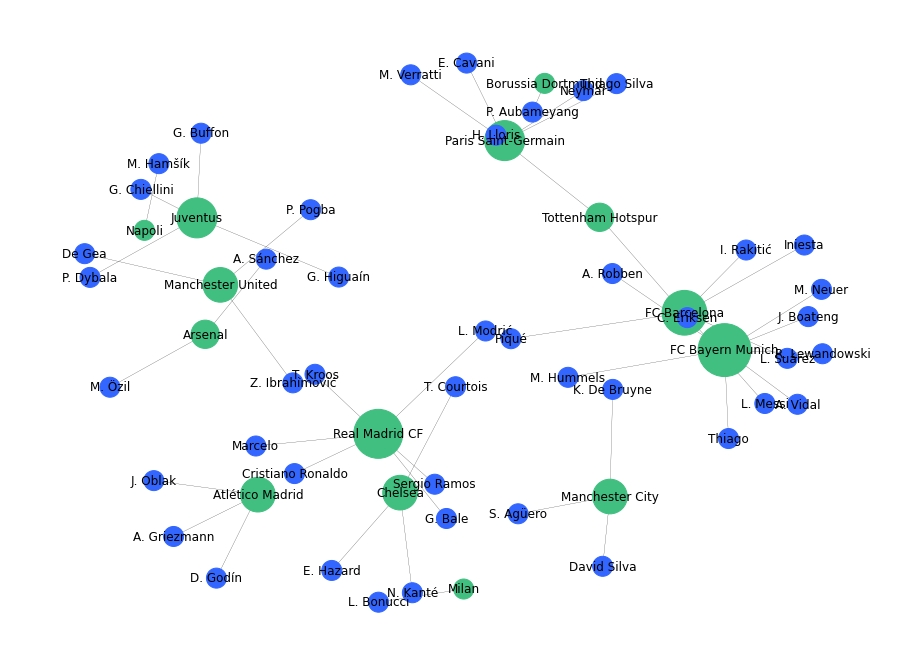

In [21]:
plt.rcParams['figure.figsize'] = [16, 12]

pos = nx.spring_layout(islands[5][1], k=2)

degree = dict(nx.degree(islands[5][1]))

degree_graph = nx.draw_networkx(islands[5][1], 
                                pos=pos,
                                node_color=node_colors,
                                #edge_color='#b3b3b3',   
                                node_size=np.multiply(list(degree.values()), 400), 
                                with_labels=True, 
                                width=0.2)

# remove axis
limits=plt.axis('off')

# Indepth analysis of the best players, their clubs and nationalities

In [22]:
best_players = fifa[fifa.Name.isin(list(islands[5][1].nodes()))]
best_players[best_players.Name == 'L. Suárez']

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,97000000.0,510000.0,ST
5052,L. Suárez,21,Argentina,70,81,Villarreal CF,3100000.0,16000.0,LM RM
11570,L. Suárez,22,Argentina,64,73,Defensa y Justicia,600000.0,3000.0,LB


In [23]:
best_players = best_players.groupby('Name', group_keys=False).apply(lambda x: x.loc[x.Overall.idxmax()])
best_players[best_players.Name == 'L. Suárez']

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions
Name,,,,,,,,,
L. Suárez,L. Suárez,30,Uruguay,92,92,FC Barcelona,97000000.0,510000.0,ST


In [24]:
best_players

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions
Name,,,,,,,,,
A. Griezmann,A. Griezmann,26,France,88,91,Atlético Madrid,75000000.0,150000.0,LW RW ST
A. Robben,A. Robben,33,Netherlands,88,88,FC Bayern Munich,36000000.0,225000.0,RW RM
A. Sánchez,A. Sánchez,28,Chile,89,89,Arsenal,67500000.0,265000.0,RM LW ST LM
A. Vidal,A. Vidal,30,Chile,87,87,FC Bayern Munich,37500000.0,160000.0,CM CDM
C. Eriksen,C. Eriksen,25,Denmark,87,91,Tottenham Hotspur,65000000.0,165000.0,LM RM CAM
Cristiano Ronaldo,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,95500000.0,565000.0,ST LW
D. Godín,D. Godín,31,Uruguay,88,88,Atlético Madrid,40000000.0,125000.0,CB
David Silva,David Silva,31,Spain,87,87,Manchester City,44000000.0,220000.0,LM CM CAM
De Gea,De Gea,26,Spain,90,92,Manchester United,64500000.0,215000.0,GK


# Players' monetary Value and Wage

In [29]:
best_players.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions,Growth
Name,,,,,,,,,,
A. Griezmann,A. Griezmann,26,France,88,91,Atlético Madrid,75000000.0,150000.0,LW RW ST,3
A. Robben,A. Robben,33,Netherlands,88,88,FC Bayern Munich,36000000.0,225000.0,RW RM,0
A. Sánchez,A. Sánchez,28,Chile,89,89,Arsenal,67500000.0,265000.0,RM LW ST LM,0
A. Vidal,A. Vidal,30,Chile,87,87,FC Bayern Munich,37500000.0,160000.0,CM CDM,0
C. Eriksen,C. Eriksen,25,Denmark,87,91,Tottenham Hotspur,65000000.0,165000.0,LM RM CAM,4


# Average Wage (in Thousands of Euros) by Club

Text(0.5, 0, 'Average Wage (in Thousands of Euros)')

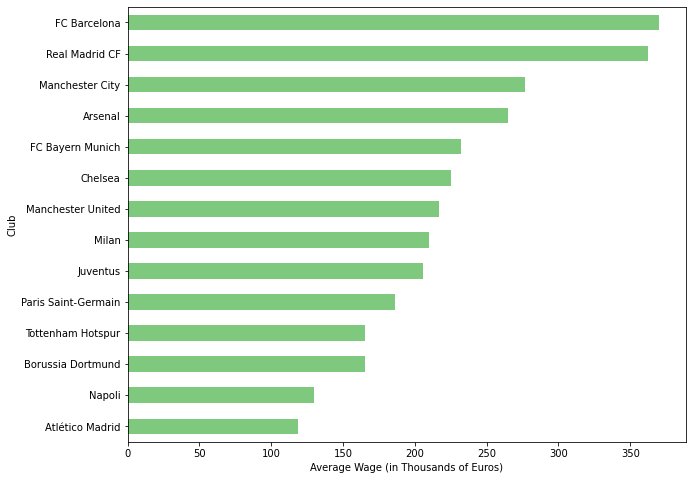

In [30]:
plt.rcParams['figure.figsize'] = [10, 8]
best_players.groupby('Club')\
    .mean().Wage\
    .apply(lambda x: x/1000).round()\
    .sort_values(ascending=True)\
    .plot(kind='barh', colormap='Accent')

plt.xlabel('Average Wage (in Thousands of Euros)')

# Clubs with the Most Valuable players

In [31]:
best_players.groupby('Club').count()

,Name,Age,Nationality,Overall,Potential,Value,Wage,Preferred Positions,Growth
Club,,,,,,,,,
Arsenal,2,2,2,2,2,2,2,2,2
Atlético Madrid,3,3,3,3,3,3,3,3,3
Borussia Dortmund,1,1,1,1,1,1,1,1,1
Chelsea,3,3,3,3,3,3,3,3,3
FC Barcelona,5,5,5,5,5,5,5,5,5
FC Bayern Munich,7,7,7,7,7,7,7,7,7
Juventus,4,4,4,4,4,4,4,4,4
Manchester City,3,3,3,3,3,3,3,3,3
Manchester United,3,3,3,3,3,3,3,3,3


Text(0.5, 0, 'Average Value (in Millions of Euros)')

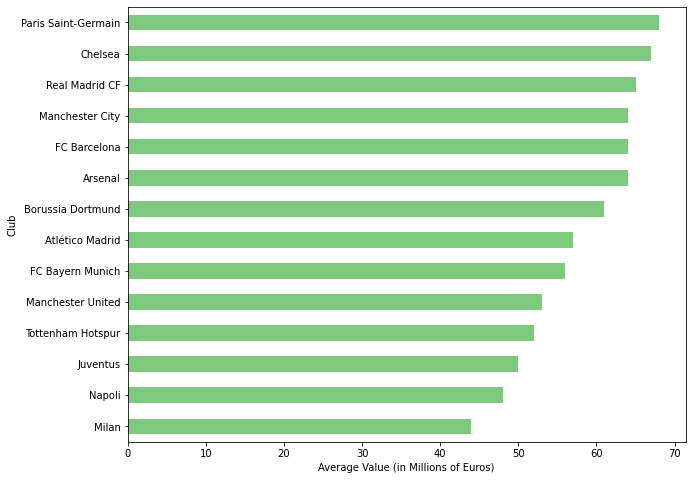

In [32]:
plt.rcParams['figure.figsize'] = [10, 8]

best_players.groupby('Club').mean().Value\
    .apply(lambda x: x/1000000).round()\
    .sort_values(ascending=True)\
    .plot(kind='barh', colormap='Accent')

plt.xlabel('Average Value (in Millions of Euros)')

Text(0.5, 0, 'Average Value (in Millions of Euros)')

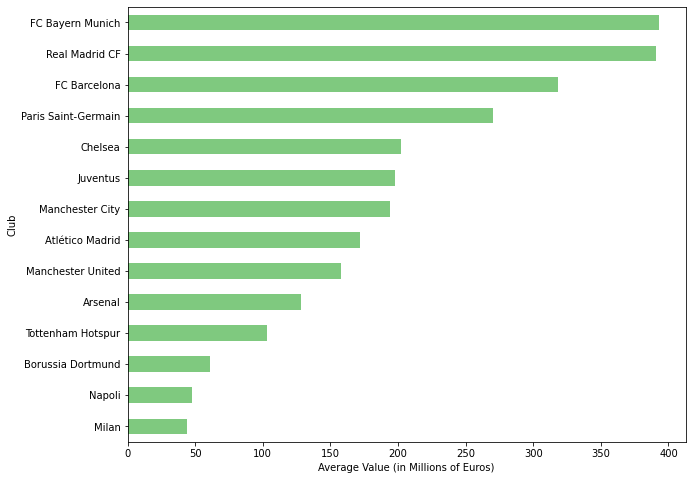

In [33]:
plt.rcParams['figure.figsize'] = [10, 8]

best_players.groupby('Club').sum().Value\
    .apply(lambda x: x/1000000).round()\
    .sort_values(ascending=True)\
    .plot(kind='barh', colormap='Accent')

plt.xlabel('Average Value (in Millions of Euros)')

# Best paid field positions

Text(0.5, 0, 'Average Wage (in Thousands of Euros)')

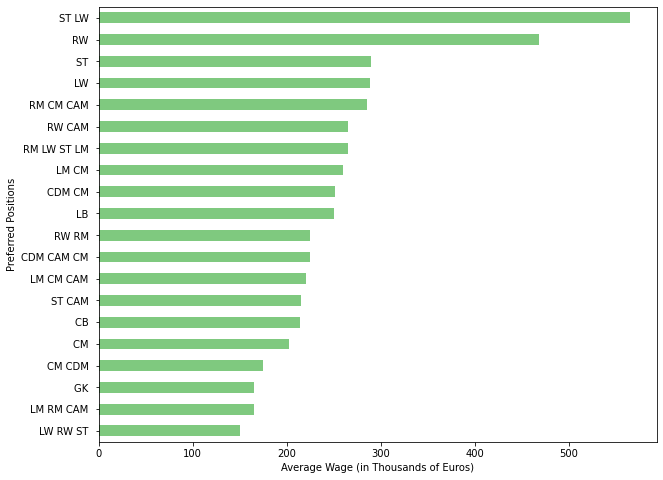

In [34]:
best_players.groupby('Preferred Positions').mean().Wage\
    .apply(lambda x: x/1000).round()\
    .sort_values(ascending=True)\
    .plot(kind='barh', colormap='Accent')
    
    
plt.xlabel('Average Wage (in Thousands of Euros)')

# Overall Performance vs Potential

In [35]:
best_players['Growth'] = best_players.Potential - best_players.Overall

best_players.nlargest(10, 'Growth')

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Positions,Growth
Name,,,,,,,,,,
J. Oblak,J. Oblak,24,Slovenia,88,93,Atlético Madrid,57000000.0,82000.0,GK,5
P. Dybala,P. Dybala,23,Argentina,88,93,Juventus,79000000.0,215000.0,ST CAM,5
P. Pogba,P. Pogba,24,France,87,92,Manchester United,66500000.0,195000.0,CDM CM,5
C. Eriksen,C. Eriksen,25,Denmark,87,91,Tottenham Hotspur,65000000.0,165000.0,LM RM CAM,4
M. Verratti,M. Verratti,24,Italy,87,91,Paris Saint-Germain,64500000.0,130000.0,CDM CM,4
A. Griezmann,A. Griezmann,26,France,88,91,Atlético Madrid,75000000.0,150000.0,LW RW ST,3
K. De Bruyne,K. De Bruyne,26,Belgium,89,92,Manchester City,83000000.0,285000.0,RM CM CAM,3
N. Kanté,N. Kanté,26,France,87,90,Chelsea,52500000.0,190000.0,CM CDM,3
T. Courtois,T. Courtois,25,Belgium,89,92,Chelsea,59000000.0,190000.0,GK,3


In [36]:
best_players.groupby('Nationality').sum().Growth.sort_values(ascending=False)

Nationality
France         11
Belgium         7
Argentina       5
Slovenia        5
Spain           4
Italy           4
Denmark         4
Brazil          2
Gabon           0
Germany         0
Croatia         0
Netherlands     0
Poland          0
Portugal        0
Slovakia        0
Chile           0
Sweden          0
Uruguay         0
Wales           0
Name: Growth, dtype: int64